In [1]:
import pandas as pd
import numpy as np
import importlib
from tqdm import tqdm
import gc
import os
from skimage.metrics import structural_similarity as ssim

# plot and image libraries
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype"
from skimage import io, color
from io import BytesIO

In [2]:
from claspy.data_loader import load_tssb_dataset
from claspy.data_loader import load_has_dataset

In [3]:
# custom utils
import mt_utils as ut

In [4]:
importlib.reload(ut)

<module 'mt_utils' from 'E:\\Melli\\HU\\Masterarbeit Save\\Implementation\\mt_utils.py'>

In [ ]:
tssb = load_tssb_dataset()
hasc = load_has_dataset()

In [ ]:
tssb_ds = pd.read_pickle('results/zwischenergebnisse/main_experiment_tssb.pkl')
hasc_ds = pd.read_pickle('results/zwischenergebnisse/main_experiment_hasc.pkl')

# Functions

In [5]:
columns = ['Algorithm','Orig_TS_ID','compression','Orig_TS','DS_TS','ClaSP_score','DSSIM','FTbSim']
algos_sorted_dsOnly = ["EveryNth","MinMax","M4","LTTB","MinMaxLTTB","LTD"]

In [6]:
def preprocess_image(image):
    # ensure image is rendered in Greyscales
    if image.ndim == 3 and image.shape[2] == 4:
        image = image[..., :3] # only use first three channels (RGB)
    if image.ndim == 3:
        image = color.rgb2gray(image)
    return image

In [7]:
def plot_to_image(ts_arr):
    # create plot image of time series and return the image as numpy array
    image_list=[]
    for ts in ts_arr:
        fig, ax = plt.subplots()
        ax.plot(ts, color='black')
        ax.axis('off')
        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        plt.close('all')
        buf.seek(0)
        image = io.imread(buf)
        buf.close()
        image_list.append(preprocess_image(image))
        images = np.asarray(image_list)
    del image, image_list
    gc.collect()
    return images

In [8]:
def calc_dssim(image1, image2): 
    # SSIM
    ssim_value = ssim(image1, image2, data_range=image1.max() - image1.min())
    
    # DSSIM
    dssim_value = (1 - ssim_value) / 2
    return dssim_value

In [9]:
def eval_downsampling_performances(df,output_file="temp_results.csv"):
    pd.DataFrame(columns=columns).to_csv(output_file, index=False)
    orig_data = df[df.Algorithm=='None']
    for index, row in tqdm(orig_data.iterrows(), total=len(orig_data), desc="Processing rows"):
        ts1 = ut.prepare_ts(row.Time_Series)           
        images1 = plot_to_image(ts1)            
        for algo in algos_sorted_dsOnly:
            algo_row = df[(df.Algorithm==algo)&(df.orig_TS_ID==row.orig_TS_ID)].T.squeeze()
            ts2 = ut.prepare_ts(algo_row.Time_Series)
            images2 = plot_to_image(ts2)
            
            dssims = [calc_dssim(images1[dim], images2[dim]) for dim in range(ts1.shape[0])]
            ftbsims = [ut.z_ED_fft(ts1[dim], ts2[dim]) for dim in range(ts1.shape[0])]
 
            result_row = {
                "Algorithm": algo,
                "Orig_TS_ID": row.orig_TS_ID,
                "compression": algo_row.compression,
                "Orig_TS": row.Time_Series,
                "DS_TS": ts2.T if ts2.shape[0] > 1 else ts2.squeeze(),
                "ClaSP_score": algo_row.score,
                "DSSIM": float(np.mean(dssims)),
                "FTbSim": float(np.mean(ftbsims)),
            }

            pd.DataFrame([result_row]).to_csv(output_file, mode='a', index=False, header=False)

            del ts2, images2, dssims, ftbsims
            gc.collect()
        
        del ts1, images1
        gc.collect()

    final_df = pd.read_csv(output_file)

    os.remove(output_file)
    return final_df

In [10]:
def plot_simMeasure_score(df,measure,xaxis_title,title, filepath=None):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df[measure], y=df.ClaSP_score,
                                mode='markers',
                                marker= dict(
                                    color='grey',
                                    size=5,
                                    line=dict(
                                        color='black',
                                        width=1
                                    )
                                )
                            )
                 )
            
    fig.update_yaxes(title_text="Covering Score")
    fig.update_xaxes(title_text=xaxis_title)
        
    fig.update_layout(height=400,
                          font=dict(
                              family="Arial",
                              size=12,
                              color="black"
                          ),
                          title=dict(
                              text=title
                          ),
                          margin=dict(l=0, r=0, t=30, b=0)
                         )
    
    if filepath:
        fig.write_image(filepath, scale=1, width=1000, height=400)
    
    fig.show()

In [11]:
def score_comparison_matrix(df, savepath=None):
    dssim_df = df[df.groupby(by='Orig_TS_ID')['DSSIM'].transform(min) == df['DSSIM']]
    mean1 = dssim_df.ClaSP_score.mean()
    median1 = dssim_df.ClaSP_score.median()
    std1 = dssim_df.ClaSP_score.std()

    ftbsim_df = df[df.groupby(by='Orig_TS_ID')['FTbSim'].transform(min) == df['FTbSim']]
    mean2 = ftbsim_df.ClaSP_score.mean()
    median2 = ftbsim_df.ClaSP_score.median()
    std2 = ftbsim_df.ClaSP_score.std()

    out = pd.DataFrame(columns=['DSSIM','FTbSim'], index=['mean','median','std'])
    out.loc['mean']=[mean1,mean2]
    out.loc['median']=[median1,median2]
    out.loc['std']=[std1,std2]
                       
    if(savepath):
        out.to_excel(savepath)

    return out

# Results

## TSSB

In [ ]:
ds_performances_tssb_df = eval_downsampling_performances(tssb_ds)

In [13]:
ds_performances_tssb_df.to_pickle('results/zwischenergebnisse/downsampling_performance_tssb.pkl')
ds_performances_tssb_df

,Algorithm,Orig_TS_ID,compression,Orig_TS,DS_TS,ClaSP_score,DSSIM,FTbSim
0,EveryNth,0,0.7,[1.681146 1.383394 1.029389 ... 1.072489 1.473...,[ 1.681146 1.383394 1.029389 0.354835 0.01...,0.480,0.032657,37.532726
1,MinMax,0,0.7,[1.681146 1.383394 1.029389 ... 1.072489 1.473...,[ 1.681146 1.029389 0.688386 0.012664 -0.31...,0.303,0.012797,37.498520
2,M4,0,0.7,[1.681146 1.383394 1.029389 ... 1.072489 1.473...,[ 1.681146 1.681146 0.012664 0.012664 -0.31...,0.303,0.044864,37.566119
3,LTTB,0,0.7,[1.681146 1.383394 1.029389 ... 1.072489 1.473...,[ 1.681146 1.383394 1.029389 0.354835 0.01...,0.621,0.016453,37.473807
4,MinMaxLTTB,0,0.7,[1.681146 1.383394 1.029389 ... 1.072489 1.473...,[ 1.681146 1.383394 1.029389 0.354835 0.01...,0.621,0.016453,37.473807
...,...,...,...,...,...,...,...,...
445,MinMax,74,0.7,[-0.155803 -0.33899 -0.564977 ... -0.205269 -...,[-0.155803 -0.564977 -0.667323 ... -0.384713 -...,0.989,0.000447,96.145401
446,M4,74,0.7,[-0.155803 -0.33899 -0.564977 ... -0.205269 -...,[-0.155803 -0.155803 -0.667323 ... -1.252174 ...,0.988,0.001027,98.328920
447,LTTB,74,0.7,[-0.155803 -0.33899 -0.564977 ... -0.205269 -...,[-0.155803 -0.33899 -0.564977 ... -0.384713 -...,0.994,0.004626,96.679823
448,MinMaxLTTB,74,0.7,[-0.155803 -0.33899 -0.564977 ... -0.205269 -...,[-0.155803 -0.33899 -0.564977 ... -0.384713 -...,0.994,0.004626,96.679823


In [14]:
ds_performances_tssb_df[['Algorithm','DSSIM','FTbSim','ClaSP_score']].groupby(by='Algorithm').mean()

,DSSIM,FTbSim,ClaSP_score
Algorithm,,,
EveryNth,0.064862,59.793584,0.785667
LTD,0.031109,55.409600,0.770907
LTTB,0.018510,59.904918,0.756467
M4,0.025107,59.791022,0.665400
MinMax,0.012098,59.759954,0.722800
MinMaxLTTB,0.018519,59.900114,0.756307


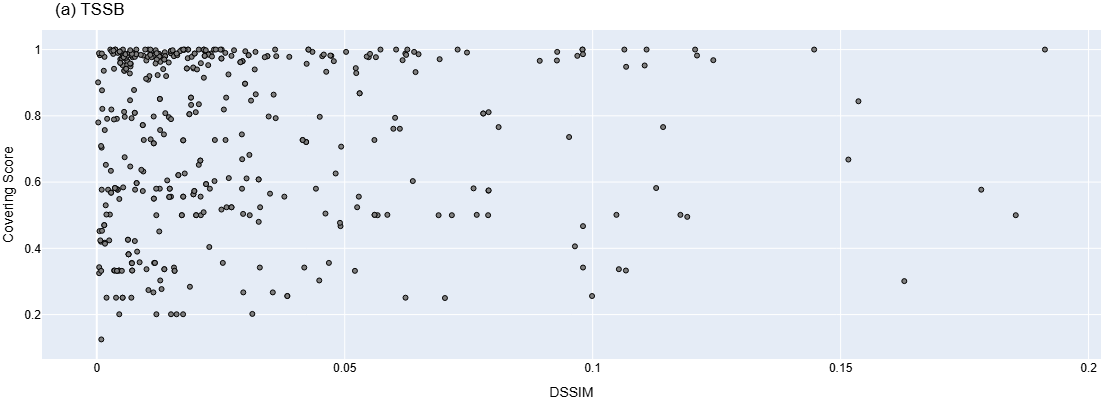

In [15]:
plot_simMeasure_score(ds_performances_tssb_df,'DSSIM','DSSIM','(a) TSSB','results/figures/downsampling_performance_DSSIM_tssb.svg')

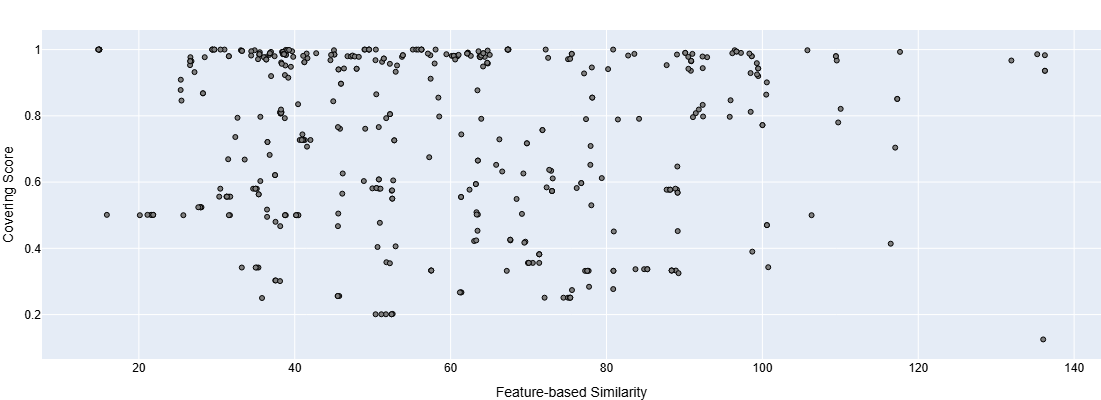

In [16]:
plot_simMeasure_score(ds_performances_tssb_df,'FTbSim','Feature-based Similarity',
                      '', 'results/figures/downsampling_performance_FTbSim_tssb.svg')

In [18]:
score_comparison_matrix(ds_performances_tssb_df, savepath='results/tables/summary_statistics_dsperformance_tssb.xlsx')

,DSSIM,FTbSim
mean,0.743744,0.775065
median,0.842,0.844
std,0.264043,0.241828


In [19]:
# this is what is possible when using the best settings, e.g. Algorithm combined with cr, upscaling and window size
# issue: how to find a prediction that approaches this setting
tmp_tssb = ds_performances_tssb_df[ds_performances_tssb_df.groupby(by='Orig_TS_ID')['ClaSP_score'].transform(max) == ds_performances_tssb_df['ClaSP_score']]
tmp_tssb[['Algorithm','ClaSP_score']].groupby(by='Algorithm').mean().T

print('Mean: {0}, Median: {1}, Std: {2}'.format(tmp_tssb.ClaSP_score.mean(),tmp_tssb.ClaSP_score.median(),tmp_tssb.ClaSP_score.std()))

Mean: 0.8171059602649007, Median: 0.977, Std: 0.22870452997460516


## HASC

In [ ]:
ds_performances_hasc_df = eval_downsampling_performances(hasc_ds)

In [21]:
ds_performances_hasc_df.to_pickle('results/zwischenergebnisse/downsampling_performance_hasc.pkl')
ds_performances_hasc_df

,Algorithm,Orig_TS_ID,compression,Orig_TS,DS_TS,ClaSP_score,DSSIM,FTbSim
0,EveryNth,0,0.6,[[ 0.406 -0.4804 1.775 ... -24.9 ...,[[ 0.406 -0.4804 1.775 ... -...,0.350,0.026678,59.278855
1,MinMax,0,0.6,[[ 0.406 -0.4804 1.775 ... -24.9 ...,[[ 0.406 -0.4804 1.775 ... -24.9 ...,0.459,0.002025,59.932277
2,M4,0,0.6,[[ 0.406 -0.4804 1.775 ... -24.9 ...,[[ 0.406 -0.4804 1.775 ... -24.9 ...,0.460,0.003030,59.305900
3,LTTB,0,0.6,[[ 0.406 -0.4804 1.775 ... -24.9 ...,[[ 0.406 -0.4804 1.775 ... -...,0.350,0.002613,60.043822
4,MinMaxLTTB,0,0.6,[[ 0.406 -0.4804 1.775 ... -24.9 ...,[[ 0.406 -0.4804 1.775 ... -...,0.350,0.002613,60.043822
...,...,...,...,...,...,...,...,...
1495,MinMax,249,0.5,[[ -4.083903 1.335141 -9.16001743 -1.7...,[[ -4.162383 1.570581 -9.16001743 -1.7...,0.892,0.000346,94.635449
1496,M4,249,0.5,[[ -4.083903 1.335141 -9.16001743 -1.7...,[[ -4.083903 1.335141 -9.16001743 -1.7...,0.998,0.000490,94.610035
1497,LTTB,249,0.5,[[ -4.083903 1.335141 -9.16001743 -1.7...,[[ -4.083903 1.335141 -9.16001743 -1.7...,0.891,0.006385,95.213182
1498,MinMaxLTTB,249,0.5,[[ -4.083903 1.335141 -9.16001743 -1.7...,[[ -4.083903 1.335141 -9.16001743 -1.7...,0.891,0.006385,95.213182


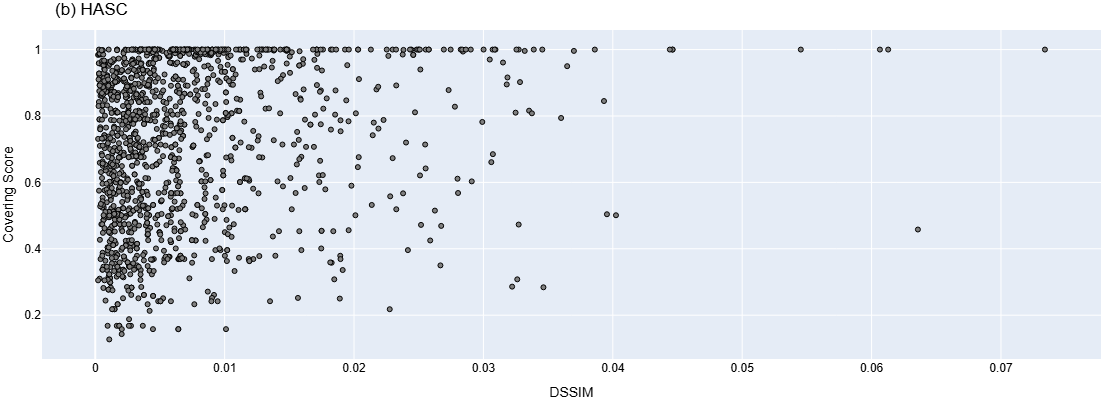

In [22]:
plot_simMeasure_score(ds_performances_hasc_df,'DSSIM','DSSIM','(b) HASC', 'results/figures/downsampling_performance_DSSIM_hasc.svg')

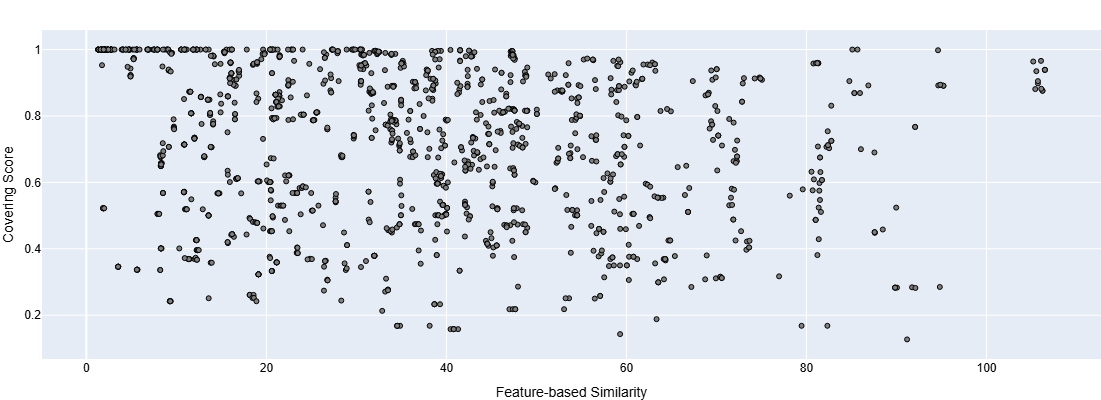

In [23]:
plot_simMeasure_score(ds_performances_hasc_df,'FTbSim','Feature-based Similarity','', 'results/figures/downsampling_performance_FTbSim_hasc.svg')

In [24]:
score_comparison_matrix(ds_performances_hasc_df, savepath='results/tables/summary_statistics_dsperformance_hasc.xlsx')

,DSSIM,FTbSim
mean,0.721681,0.72251
median,0.777,0.783
std,0.229206,0.233009


In [25]:
# what is possible with best settings
tmp_hasc = ds_performances_hasc_df[ds_performances_hasc_df.groupby(by='Orig_TS_ID')['ClaSP_score'].transform(max) == ds_performances_hasc_df['ClaSP_score']]
tmp_hasc[['Algorithm','ClaSP_score']].groupby(by='Algorithm').mean().T

print('Mean: {0}, Median: {1}, Std: {2}'.format(tmp_hasc.ClaSP_score.mean(),tmp_hasc.ClaSP_score.median(),tmp_hasc.ClaSP_score.std()))

Mean: 0.7888662092624357, Median: 0.873, Std: 0.22880072650079034
